# Hildebrand Local Thickness Algorithm Notebook

Investigate the local thickness of structures in Python.

In [1]:
import numpy as np
import SimpleITK as sitk

from matplotlib import pyplot as plt

from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics
from ormir_xct.segmentation.ipl_seg import ipl_seg

Synthetic shape mask functions:

In [2]:
def create_shape(shape, voxel_widths, thickness, shape_type="sphere"):
    center = (
        voxel_widths[0] * (shape[0] // 2), 
        voxel_widths[1] * (shape[1] // 2), 
        voxel_widths[2] * (shape[2] // 2)
    )
    x, y, z = np.meshgrid(*[voxel_widths[i] * np.arange(0, shape[i]) for i in range(3)], indexing="ij")
    if shape_type == "sphere":
        mask = (((x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "cylinder":
        mask = (((x-center[0])**2 + (y-center[1])**2) < (thickness/2)**2).astype(int)
    elif shape_type == "plate":
        mask = (np.abs(x-center[0]) < thickness/2).astype(int)
    else:
        raise ValueError(f"`shape_type` can be `sphere`, `cylinder`, `plate`; got {shape_type}")
    return mask

    

Generate a synthetic sphere, cylinder, and plate:

In [3]:
shape = tuple([50]*3)
voxel_widths = tuple([0.0607]*3)
radius = 1

sphere = create_shape(shape, voxel_widths, radius, shape_type="sphere")
cylinder = create_shape(shape, voxel_widths, radius, shape_type="cylinder")
plate = create_shape(shape, voxel_widths, radius, shape_type="plate")

#sitk.compare(sphere, cylinder, link_cmap=True, axes=True, rotate=True)

In [4]:
#compare(sphere, plate, link_cmap=True, axes=True, rotate=True)

Check their estimated mean thicknesses:

In [5]:
sphere_thickness_stats = calc_structure_thickness_statistics(sphere, voxel_widths, 0)
cylinder_thickness_stats = calc_structure_thickness_statistics(cylinder, voxel_widths, 0)
plate_thickness_stats = calc_structure_thickness_statistics(plate, voxel_widths, 0)

In [6]:
print(f"Sphere thickness is {sphere_thickness_stats[0]:0.3f} +/- {sphere_thickness_stats[1]:0.3f}")
print(f"Cylinder thickness is {cylinder_thickness_stats[0]:0.3f} +/- {cylinder_thickness_stats[1]:0.3f}")
print(f"Plate thickness is {plate_thickness_stats[0]:0.3f} +/- {plate_thickness_stats[1]:0.3f}")

Sphere thickness is 0.898 +/- 0.000
Cylinder thickness is 0.929 +/- 0.000
Plate thickness is 1.032 +/- 0.000


This checks out because we set `radius = 1` when we generated these shapes.

Now we can do a sweep over spheres, cylinders, and plates of various thicknesses to see how well we can estimate the thickness of these shapes at various resolutions.

In [7]:
shape = (100, 100, 100)
voxel_widths = (1, 1, 1)

true_thicknesses = np.arange(5, 50, 5)

est_sph_thicknesses = []
est_cyl_thicknesses = []
est_plt_thicknesses = []

for thickness in true_thicknesses:
    print(f"thickness: {thickness}")
    
    sphere = create_shape(shape, voxel_widths, thickness, shape_type="sphere")
    est_sph_thicknesses.append(calc_structure_thickness_statistics(sphere, voxel_widths, 0)[0])
    
    cylinder = create_shape(shape, voxel_widths, thickness, shape_type="cylinder")
    est_cyl_thicknesses.append(calc_structure_thickness_statistics(cylinder, voxel_widths, 0)[0])
    
    plate = create_shape(shape, voxel_widths, thickness, shape_type="plate")
    est_plt_thicknesses.append(calc_structure_thickness_statistics(plate, voxel_widths, 0)[0])

thickness: 5
thickness: 10
thickness: 15
thickness: 20
thickness: 25
thickness: 30
thickness: 35
thickness: 40
thickness: 45


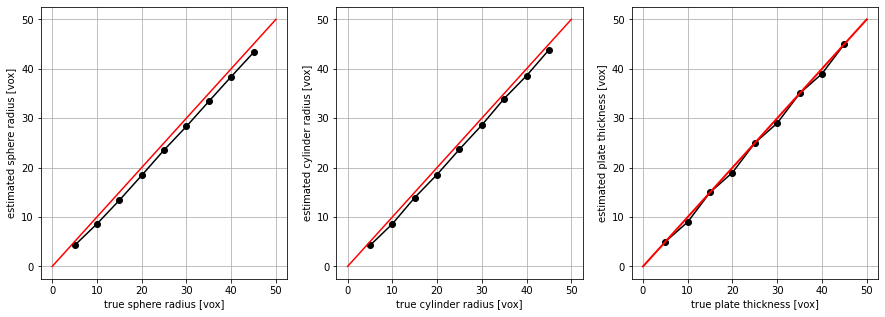

In [8]:
max_size = max(shape)//2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(true_thicknesses, est_sph_thicknesses, "k-o")
axs[0].plot([0, max_size], [0, max_size], "r-")
axs[0].grid()

axs[0].set_xlabel("true sphere radius [vox]")
axs[0].set_ylabel("estimated sphere radius [vox]")

axs[1].plot(true_thicknesses, est_cyl_thicknesses, "k-o")
axs[1].plot([0, max_size], [0, max_size], "r-")
axs[1].grid()

axs[1].set_xlabel("true cylinder radius [vox]")
axs[1].set_ylabel("estimated cylinder radius [vox]")

axs[2].plot(true_thicknesses, est_plt_thicknesses, "k-o")
axs[2].plot([0, max_size], [0, max_size], "r-", linewidth=2)
axs[2].grid()

axs[2].set_xlabel("true plate thickness [vox]")
axs[2].set_ylabel("estimated plate thickness [vox]")

plt.show()

If you have run the JSW example notebook, there will be a saved image that has the joint pace mask for a finger joint. We can also investigate that as an example here...

In [9]:
data_fn = "../tests/data/JS_MASK.mha"
js_mask = sitk.GetArrayFromImage(sitk.ReadImage(data_fn)) > 0
voxel_widths = (0.0607, 0.0607, 0.0607)

In [10]:
js_stats = calc_structure_thickness_statistics(js_mask, voxel_widths, 2*0.0607)

In [11]:
jsv = js_mask.sum()*voxel_widths[0]*voxel_widths[1]*voxel_widths[2]
print(f"JSV     : {jsv:0.3f} mm^3")
print(f"JSW.mean: {js_stats[0]:0.3f} mm")
print(f"JSW.std : {js_stats[1]:0.3f} mm")
print(f"JSW.min : {js_stats[2]:0.3f} mm")
print(f"JSW.max : {js_stats[3]:0.3f} mm")

JSV     : 65.246 mm^3
JSW.mean: 1.359 mm
JSW.std : 0.200 mm
JSW.min : 0.121 mm
JSW.max : 1.623 mm


We can also attempt to do some microarchitectural analysis. Load a preprocessed sample HR-pQCT tibia image:

In [12]:
data_fn = "/Users/nathanneeteson/Documents/Data/Images/UNet/NORMXTII_0051_TL.npz"
with np.load(data_fn) as data:
    image = data["image"]
    cort_mask = data["cort_mask"]
    trab_mask = data["trab_mask"]

cort_thresh = 450
trab_thresh = 320

cort_bone_mask = cort_mask & (
    sitk.GetArrayFromImage(
        ipl_seg(
            sitk.GetImageFromArray(image),
            cort_thresh,
            1e10,  # crazy high number because there's no upper thresh
            voxel_size=1,
            sigma=0.8
        )
    )
    == 127
)

trab_bone_mask = trab_mask & (
    sitk.GetArrayFromImage(
        ipl_seg(
            sitk.GetImageFromArray(image),
            trab_thresh,
            1e10,  # crazy high number because there's no upper thresh
            voxel_size=1,
            sigma=0.8
        )
    )
    == 127
)

Plot a slice with `pyplot` quickly to make sure the data loaded correctly:

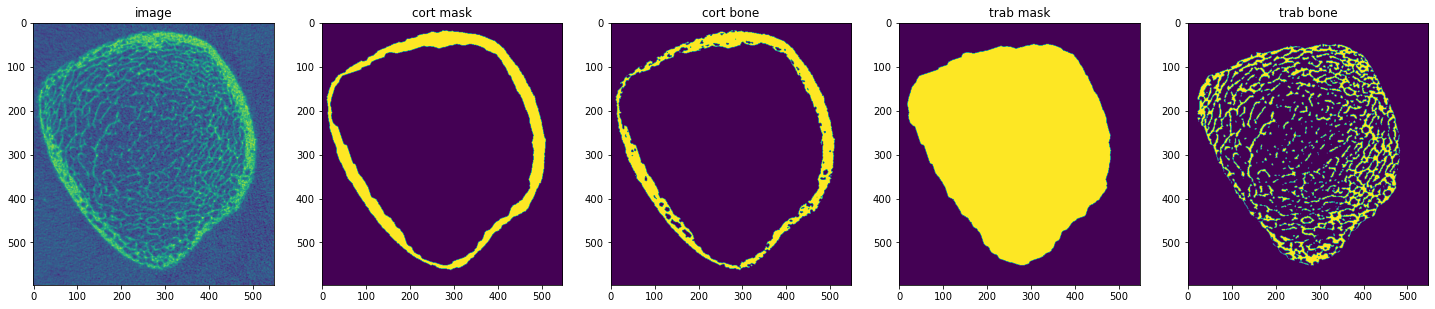

In [13]:
fig, axs = plt.subplots(1,5, figsize=(25,5))

axs[0].imshow(image[:,:,168//2])
axs[0].set_title("image")

axs[1].imshow(cort_mask[:,:,168//2])
axs[1].set_title("cort mask")

axs[2].imshow(cort_bone_mask[:,:,168//2])
axs[2].set_title("cort bone")

axs[3].imshow(trab_mask[:,:,168//2])
axs[3].set_title("trab mask")

axs[4].imshow(trab_bone_mask[:,:,168//2])
axs[4].set_title("trab bone")

plt.show()

Get the thickness stats from the cortical mask to calculate `Ct.Th`:

In [ ]:
cort_thickness_stats = calc_structure_thickness_statistics(cort_mask, (0.0607, 0.0607, 0.0607), 0.0607)

In [ ]:
print(f"Ct.Th: {cort_thickness_stats[0]:0.3f} mm")

The reference value is 1.379 mm.

Now try calculating `Tb.Th`:

In [ ]:
trab_bone_thickness_stats = calc_structure_thickness_statistics(trab_bone_mask, (0.0607, 0.0607, 0.0607), 0.0607)

The reference value is 0.271 mm

In [ ]:
print(f"Tb.Th: {trab_bone_thickness_stats[0]:0.3f} mm")

In [ ]:
print("           |  Python  | Reference (IPL)")
print("----------------------------------------")
print(f"Ct.Th [mm] |    {cort_thickness_stats[0]:0.3f} | 1.379 ")
print(f"Tb.Th [mm] |    {trab_bone_thickness_stats[0]:0.3f} | 0.271 ")